# Setup

In [1]:
import os
print("Current Working Directory " , os.getcwd())
import sys
sys.path.append("../") # Add directory containing src/data to path

Current Working Directory  /scratch/work/mohamma10/posterior-network/Posterior-Network/notebooks


In [2]:
import torch
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
from torch import nn
from tqdm import tqdm

# Dataset

In [3]:
from src.dataset_manager.CustomDataset import CustomDataset
from torch.utils.data import DataLoader

data_root_dir='../data/CIFAR-10-C'

Samples from dataset

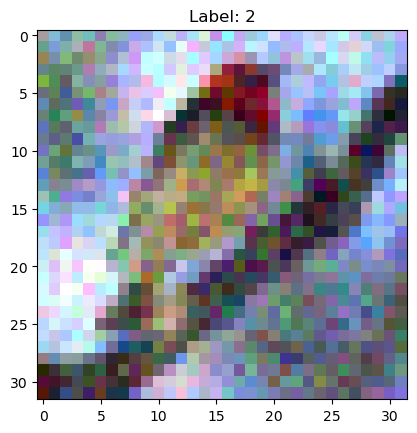

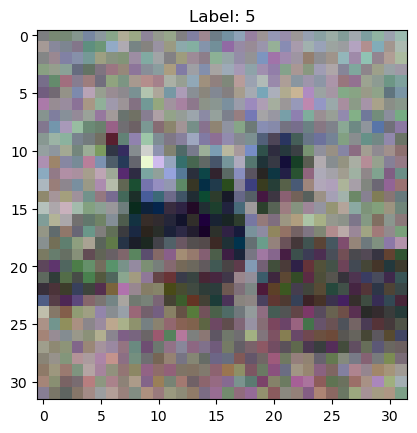

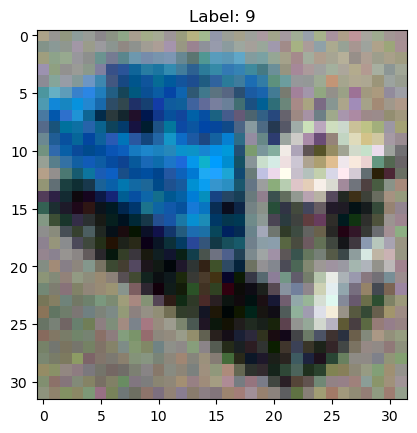

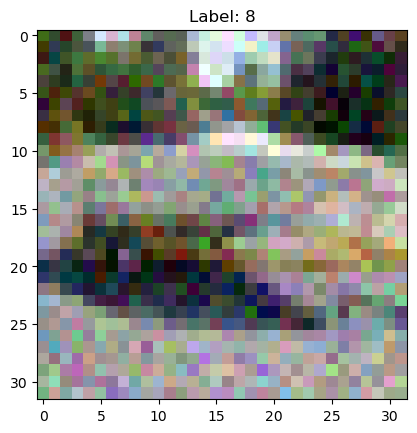

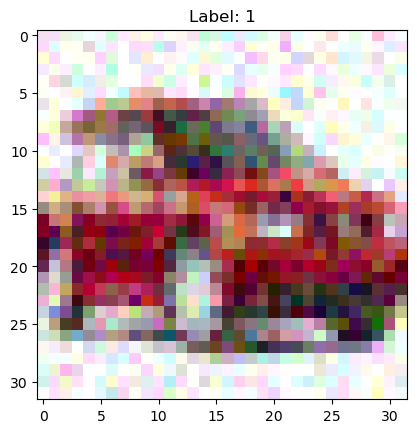

In [13]:
sampleset = CustomDataset(images_path=f"{data_root_dir}/gaussian_noise", labels_path=f"{data_root_dir}/labels")
samples, labels = sampleset[np.random.randint(low=0, high=len(sampleset), size=5)]

for i in range(len(samples)):
    sample = samples[i]
    label = labels[i]
    
    # Plot the sample
    plt.imshow(sample)
    plt.title(f'Label: {label}')
    plt.show()

# Results

In [62]:
results_dir = '../saved_results/CIFAR-10-C'
csv_files = [file for file in os.listdir(results_dir) if file.endswith('.csv')]

results = pd.DataFrame()
for file in csv_files:
    file_path = os.path.join(results_dir, file)
    df = pd.read_csv(file_path, index_col=0)
    results = pd.concat([results, df])

columns_to_exclude = ['spatter', 'saturate', 'speckle_noise', 'gaussian_blur']

results.drop(columns=columns_to_exclude, inplace=True)
results['mean'] = results.mean(axis=1)
results*100

,gaussian_noise,motion_blur,glass_blur,snow,contrast,impulse_noise,shot_noise,brightness,pixelate,elastic_transform,zoom_blur,jpeg_compression,fog,frost,defocus_blur,mean
pn_conv,29.830,30.842,28.574,23.438,49.366,37.236,25.266,16.420,16.966,22.916,27.470,18.142,33.342,25.340,23.464,27.240800
pn_alexnet,46.156,31.006,29.306,26.798,50.678,42.428,38.596,17.148,16.136,22.720,27.542,17.838,34.420,28.922,24.364,30.270533
pn_vgg16,41.796,23.486,27.758,18.298,35.436,36.672,32.528,7.726,15.046,14.186,21.002,13.904,20.866,20.360,16.896,23.064000
alexnet_baseline,39.588,27.470,23.006,24.748,50.234,43.594,31.900,17.106,14.170,21.064,24.318,16.472,33.910,27.542,21.834,27.797067
pn_resnet,45.990,24.340,29.858,19.232,29.662,35.764,36.566,8.944,15.658,15.034,21.318,16.120,15.342,20.450,17.576,23.456933


In [61]:
normalized = results.div(results.loc['alexnet_baseline'], axis='columns')*100
normalized['mCE'] = normalized.mean(axis=1)
normalized = normalized.astype(int)
normalized

,gaussian_noise,motion_blur,glass_blur,snow,contrast,impulse_noise,shot_noise,brightness,pixelate,elastic_transform,zoom_blur,jpeg_compression,fog,frost,defocus_blur,mCE
pn_conv,75,112,124,94,98,85,79,95,119,108,112,110,98,92,107,100
pn_alexnet,116,112,127,108,100,97,120,100,113,107,113,108,101,105,111,109
pn_vgg16,105,85,120,73,70,84,101,45,106,67,86,84,61,73,77,82
alexnet_baseline,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100,100
pn_resnet,116,88,129,77,59,82,114,52,110,71,87,97,45,74,80,85


# Testing

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")
num_workers = 0

device: cpu


In [6]:
from src.posterior_networks.PosteriorNetwork import PosteriorNetwork


seed_model=123
architecture='resnet'
input_dims=[32, 32, 3]
output_dim=10
hidden_dims=[64, 64, 64]
kernel_dim=5
latent_dim=6
no_density=False
density_type='radial_flow'
n_density=6
k_lipschitz=None
budget_function='id'
N = torch.tensor([3543., 3644., 3570., 3593., 3633., 3539., 3647., 3577., 3693., 3561.])
batch_size=256
lr=5e-4
loss='UCE'
training_mode='joint'
regr=1e-5

model = PosteriorNetwork(N=N,
                        input_dims=input_dims,
                        output_dim=output_dim,
                        hidden_dims=hidden_dims,
                        kernel_dim=kernel_dim,
                        latent_dim=latent_dim,
                        architecture=architecture,
                        k_lipschitz=k_lipschitz,
                        no_density=no_density,
                        density_type=density_type,
                        n_density=n_density,
                        budget_function=budget_function,
                        batch_size=batch_size,
                        lr=lr,
                        loss=loss,
                        regr=regr,
                        seed=seed_model)

model_path = '../saved_models/model-dpn-123-CIFAR10-[0.6, 0.8]-0.0-255.0-123-resnet-[32, 32, 3]-10-[64, 64, 64]-5-6-False-radial_flow-6-None-id-200-20-2-256-0.0005-UCE-joint-1e-05-8'
model.load_state_dict(torch.load(model_path, map_location=device)['model_state_dict'])
model.to(device)

/appl/scibuilder-mamba/aalto-rhel9/prod/software/scicomp-python-env/2024-01/f56a564/lib/python3.11/site-packages/torch/__init__.py:696: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1711403378171/work/torch/csrc/tensor/python_tensor.cpp:451.)
  _C._set_default_tensor_type(t)


PosteriorNetwork(
  (sequential): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)

In [9]:
import torchvision.transforms as trn

corruptions = [
                'gaussian_noise','motion_blur','glass_blur','saturate','snow',
                'spatter','contrast','impulse_noise','speckle_noise','gaussian_blur',
                'shot_noise','brightness','pixelate','elastic_transform','zoom_blur',
                'jpeg_compression','fog','frost','defocus_blur'
]

transform = trn.Compose([trn.ToTensor(), trn.Normalize(0, 255)])
batch_size=16

In [15]:
dataset[0]

(tensor([[[0.0024, 0.0024, 0.0025,  ..., 0.0022, 0.0020, 0.0015],
          [0.0025, 0.0025, 0.0025,  ..., 0.0024, 0.0016, 0.0018],
          [0.0025, 0.0023, 0.0024,  ..., 0.0024, 0.0016, 0.0021],
          ...,
          [0.0009, 0.0004, 0.0007,  ..., 0.0004, 0.0001, 0.0005],
          [0.0010, 0.0007, 0.0006,  ..., 0.0004, 0.0005, 0.0003],
          [0.0009, 0.0008, 0.0006,  ..., 0.0002, 0.0006, 0.0004]],
 
         [[0.0017, 0.0015, 0.0018,  ..., 0.0012, 0.0013, 0.0012],
          [0.0017, 0.0021, 0.0017,  ..., 0.0015, 0.0013, 0.0016],
          [0.0017, 0.0015, 0.0015,  ..., 0.0015, 0.0015, 0.0013],
          ...,
          [0.0021, 0.0017, 0.0014,  ..., 0.0016, 0.0012, 0.0012],
          [0.0018, 0.0012, 0.0014,  ..., 0.0013, 0.0015, 0.0008],
          [0.0016, 0.0013, 0.0012,  ..., 0.0013, 0.0014, 0.0012]],
 
         [[0.0007, 0.0008, 0.0008,  ..., 0.0006, 0.0004, 0.0005],
          [0.0006, 0.0007, 0.0006,  ..., 0.0004, 0.0005, 0.0007],
          [0.0008, 0.0002, 0.0005,  ...,

In [34]:
model.eval()
corruption = corruptions[0]
transform = trn.Compose([trn.ToTensor()])
dataset = CustomDataset(images_path=f"{data_root_dir}/{corruption}", labels_path=f"{data_root_dir}/labels", transform=transform)
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

In [35]:
correct = 0
data, target = next(iter(data_loader))
data = data.double().to(device)
target = target.to(device)
print(target)
pred = model(data, None, return_output='hard', compute_loss=False)
print(pred)
correct += pred.eq(target).sum()
(1 - 1.*correct/len(dataset)).item()

tensor([8, 2, 9, 7, 2, 7, 9, 2, 7, 9, 0, 7, 2, 8, 6, 7])
tensor([8, 6, 9, 3, 2, 6, 3, 6, 3, 9, 0, 7, 2, 8, 6, 4])


0.99982

In [37]:
data.min()

tensor(0.)

In [18]:
target

tensor([3, 8, 8, 0, 6, 6, 1, 6, 3, 1, 0, 9, 5, 7, 9, 8])

In [17]:
correct

tensor(2)